# Sleep Health Exploratory Data Analysis and Prediction
The dataset covers a wide range of variables related to sleep and daily habits 

### Key Features of the Dataset:
* Comprehensive Sleep Metrics: Explore sleep duration, quality, and factors influencing sleep patterns.
* Lifestyle Factors: Analyze physical activity levels, stress levels, and BMI categories.
* Cardiovascular Health: Examine blood pressure and heart rate measurements.
* Sleep Disorder Analysis: Identify the occurrence of sleep disorders such as Insomnia and Sleep Apnea.

### In this notebook:
* The dataset is explored with helpful charts that give an initial view on the data
* The data is cleaned and prepared for creating the machine learning models
* Several models are created and compared based on meaningful metrics

In [1]:
# Importing Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px


from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

## 1. Data Loading

In [2]:
# For kaggle
#sleep_data = pd.read_csv('/kaggle/input/sleep-health-and-lifestyle-dataset/Sleep_health_and_lifestyle_dataset.csv')

# For local
sleep_data = pd.read_csv('Sleep_health_and_lifestyle_dataset.csv')
sleep_data.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [3]:
sleep_data.shape

(374, 13)

In [4]:
# Person ID is not needed for the model
sleep_data.drop(columns='Person ID',inplace=True)

In [5]:
# Renaming columns to lowercase and replacing spaces with underscores
sleep_data.columns = [i.lower().replace(' ', '_') for i in sleep_data.columns]

In [6]:
sleep_data.head()

,gender,age,occupation,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,bmi_category,blood_pressure,heart_rate,daily_steps,sleep_disorder
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None
1,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
3,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [7]:
sleep_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gender                   374 non-null    object 
 1   age                      374 non-null    int64  
 2   occupation               374 non-null    object 
 3   sleep_duration           374 non-null    float64
 4   quality_of_sleep         374 non-null    int64  
 5   physical_activity_level  374 non-null    int64  
 6   stress_level             374 non-null    int64  
 7   bmi_category             374 non-null    object 
 8   blood_pressure           374 non-null    object 
 9   heart_rate               374 non-null    int64  
 10  daily_steps              374 non-null    int64  
 11  sleep_disorder           374 non-null    object 
dtypes: float64(1), int64(6), object(5)
memory usage: 35.2+ KB


In [8]:
sleep_data.isna().sum()

gender                     0
age                        0
occupation                 0
sleep_duration             0
quality_of_sleep           0
physical_activity_level    0
stress_level               0
bmi_category               0
blood_pressure             0
heart_rate                 0
daily_steps                0
sleep_disorder             0
dtype: int64

There are no null values in the dataset

Splitting the `blood_pressure` data into `systolic` and diastolic `columns`

In [9]:
sleep_data.blood_pressure.unique()

array(['126/83', '125/80', '140/90', '120/80', '132/87', '130/86',
       '117/76', '118/76', '128/85', '131/86', '128/84', '115/75',
       '135/88', '129/84', '130/85', '115/78', '119/77', '121/79',
       '125/82', '135/90', '122/80', '142/92', '140/95', '139/91',
       '118/75'], dtype=object)

In [10]:
# Splitting the blood pressure into two columns so it can be processed and visualized easier
sleep_data[['systolic', 'diastolic']
           ] = sleep_data.blood_pressure.str.split('/', expand=True)

sleep_data['systolic'] = sleep_data['systolic'].astype('int')
sleep_data['diastolic'] = sleep_data['diastolic'].astype('int')
sleep_data.drop('blood_pressure', axis=1, inplace=True)

## 2. Exploratory Data Analysis

### Based on the gender

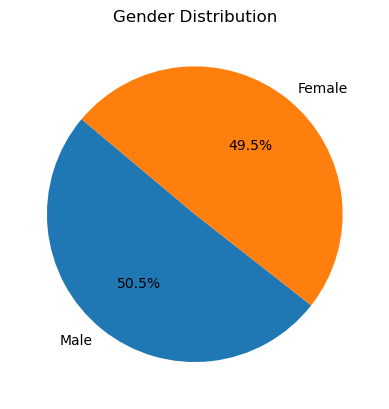

In [11]:
# A pie chart representing the percentages of males and females
plt.pie(sleep_data['gender'].value_counts().values,
        labels=sleep_data['gender'].value_counts().index, autopct='%1.1f%%', startangle=140)

plt.title('Gender Distribution')

plt.show()

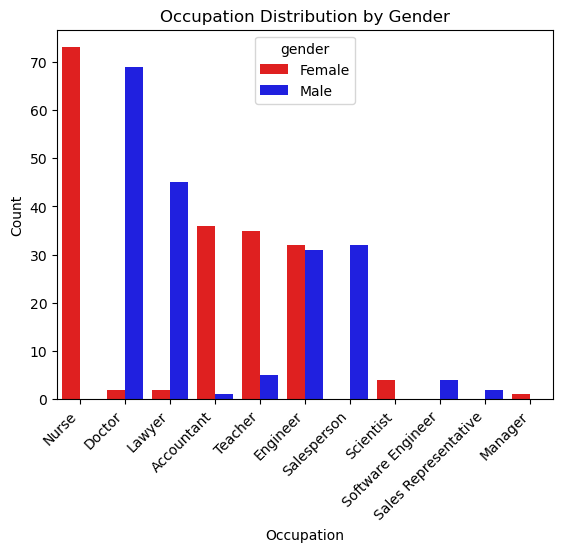

In [12]:
# Grouping The occupation column by gender to see if some occupations are dominated by either gender
gender_by_occupation = sleep_data.groupby(
    ['occupation', 'gender']).size().reset_index(name='count')

gender_colors = {'Male': 'blue', 'Female': 'red'}

# Sort the data by count
gender_by_occupation = gender_by_occupation.sort_values(
    by='count', ascending=False)


# Plot the data
sns.barplot(y='count', x='occupation', hue='gender', data=gender_by_occupation,
            palette=gender_colors, width=0.8)

# Set the title and axis labels
plt.title('Occupation Distribution by Gender')
plt.xlabel('Occupation')
plt.ylabel('Count')

plt.xticks(rotation=45, ha='right')


# Show the plot
plt.show()

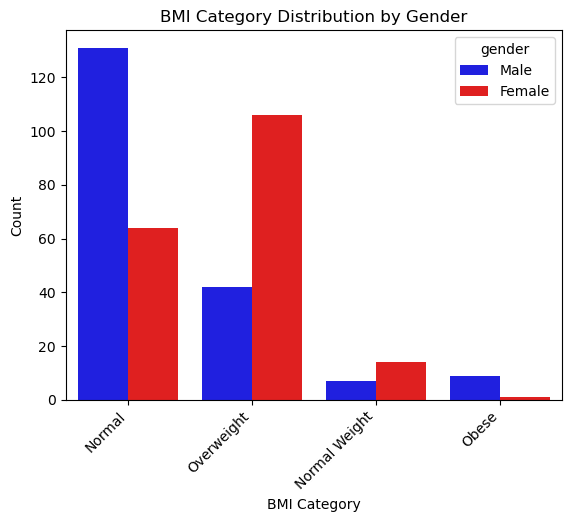

In [13]:
# Grouping the BMI Category by Gender
gender_by_bmi = sleep_data.groupby(
    ['bmi_category', 'gender']).size().reset_index(name='count')

gender_colors = {'Male': 'blue', 'Female': 'red'}

# Sort the data by count
gender_by_bmi = gender_by_bmi.sort_values(
    by='count', ascending=False)


# Plot the data
sns.barplot(y='count', x='bmi_category', hue='gender', data=gender_by_bmi,
            palette=gender_colors, width=0.8)

# Set the title and axis labels
plt.title('BMI Category Distribution by Gender')
plt.xlabel('BMI Category')
plt.ylabel('Count')

plt.xticks(rotation=45, ha='right')


# Show the plot
plt.show()

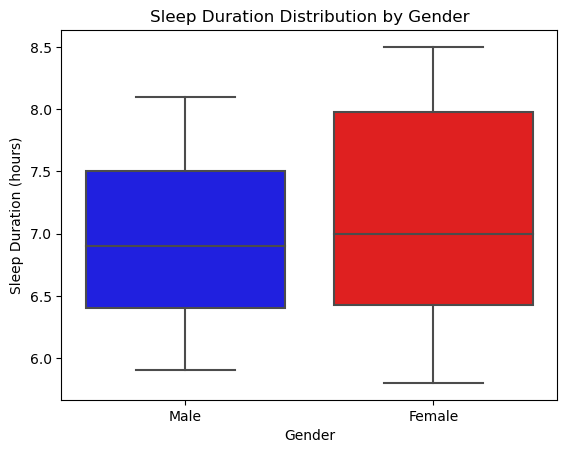

In [14]:
# Grouping the sleep duration column by the gender
sleep_duration_by_gender = sleep_data.groupby(
    ['sleep_duration', 'gender']).size().reset_index(name='count')

gender_colors = {'Male': 'blue', 'Female': 'red'}

# Sort the data by count
sleep_duration_by_gender = sleep_duration_by_gender.sort_values(
    by='count', ascending=False)


# Plot the data
sns.boxplot(y='sleep_duration', x='gender', data=sleep_duration_by_gender,
            palette=gender_colors,)

# Set the title and axis labels
plt.title('Sleep Duration Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Sleep Duration (hours)')

# Show the plot
plt.show()

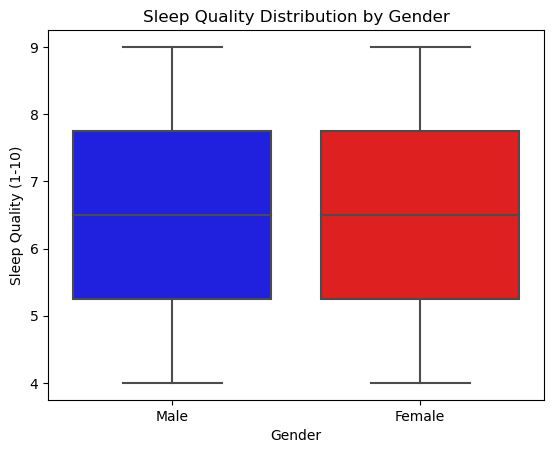

In [15]:
# Grouping the quality of sleep column by gender
sleep_quality_by_gender = sleep_data.groupby(
    ['quality_of_sleep', 'gender']).size().reset_index(name='count')

gender_colors = {'Male': 'blue', 'Female': 'red'}

# Sort the data by count
sleep_quality_by_gender = sleep_quality_by_gender.sort_values(
    by='count', ascending=False)


# Plot the data
sns.boxplot(y='quality_of_sleep', x='gender', data=sleep_quality_by_gender,
            palette=gender_colors,)

# Set the title and axis labels
plt.title('Sleep Quality Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Sleep Quality (1-10)')

# Show the plot
plt.show()

***Main Conclusions***
* The dataset exhibits a nearly equal distribution of gender, with approximately half of the observations belonging to males and the other half to females.

* In the dataset, a significant number of occupations display gender dominance, wherein one gender constitutes a substantially higher proportion within specific professions.

* An interesting finding within the dataset reveals a notable disparity between genders concerning weight issues. Females are observed to be considerably more susceptible to weight-related problems compared to males.

* The dataset's analysis also highlights variations in sleep duration between genders. On average, females tend to have a longer duration of sleep compared to their males.

* There is a similarity in the reported sleep quality between males and females, with both genders typically rating their sleep quality within the range of 6 to 8 on a scale of 1 to 10.

### Based on the Occupation

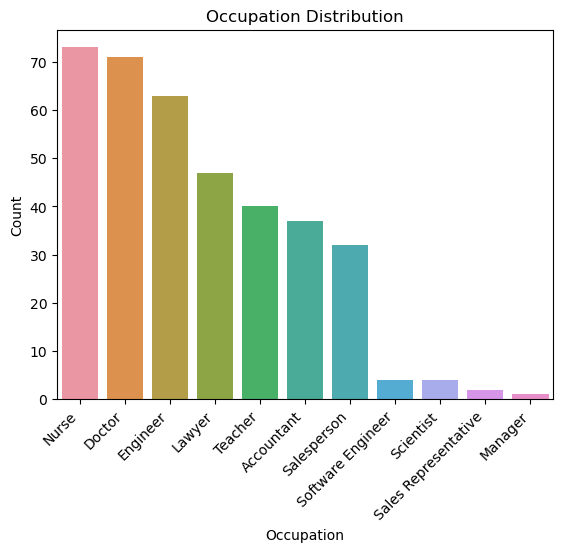

In [16]:
# Sorting the occupations by number of people who belong to them
occupation_counts = sleep_data['occupation'].value_counts(
).sort_values(ascending=False)


sns.barplot(x=occupation_counts.index, y=occupation_counts.values)

# Setting titles
plt.title('Occupation Distribution')
plt.xlabel('Occupation')
plt.ylabel('Count')

plt.xticks(rotation=45, ha='right')

plt.show()

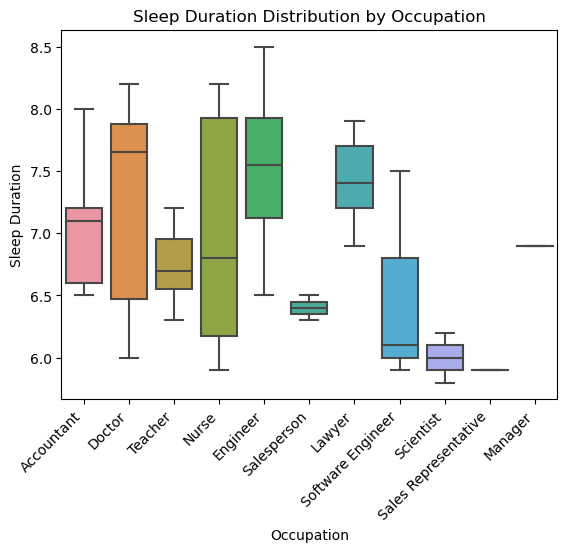

In [17]:
# Grouping the sleep duration column by the occupation
sleep_duration_by_occupation = sleep_data.groupby(
    ['sleep_duration', 'occupation']).size().reset_index(name='count')


# Sort the data by count
sleep_duration_by_occupation = sleep_duration_by_occupation.sort_values(
    by='count', ascending=False)


# Plot the data
sns.boxplot(y='sleep_duration', x='occupation',
            data=sleep_duration_by_occupation)

# Set the title and axis labels
plt.title('Sleep Duration Distribution by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Sleep Duration')


plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

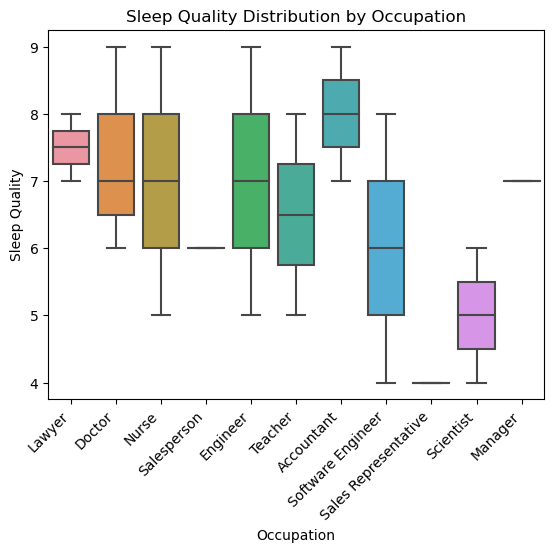

In [18]:
# Grouping the quality of sleep column by the occupation
sleep_quality_by_occupation = sleep_data.groupby(
    ['quality_of_sleep', 'occupation']).size().reset_index(name='count')


# Sort the data by count
sleep_quality_by_occupation = sleep_quality_by_occupation.sort_values(
    by='count', ascending=False)


# Plot the data
sns.boxplot(y='quality_of_sleep', x='occupation',
            data=sleep_quality_by_occupation)

# Set the title and axis labels
plt.title('Sleep Quality Distribution by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Sleep Quality')


plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

***Main Conclusions***
* The dataset reveals substantial variations in sleep durations among different occupations. Salespersons, teachers, nurses and accountants tend to report the lowest sleep durations, while lawyers, engineers, and doctors report the longest sleep durations. Among doctors and nurses, there is considerable variation, with doctors reporting the most sleep and nurses having significantly less sleep.

* In terms of sleep quality, as measured on a scale of 1 to 10, the majority of occupations reported comparable values, with a predominant concentration falling between 6 and 8. However, notable differences can be observed within specific professions. Accountants and lawyers tend to have higher reported sleep quality, while salespersons and teachers reported lower sleep quality scores.

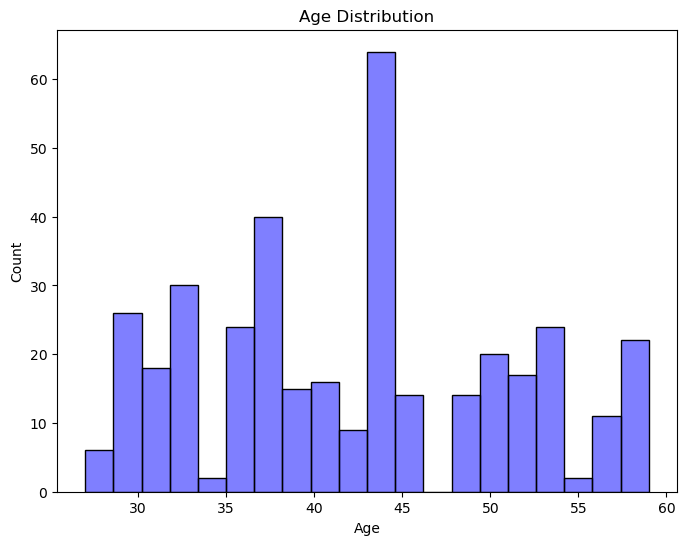

In [19]:
# Plotting the Age Distrubution in the dataset
plt.figure(figsize=(8, 6))

sns.histplot(data=sleep_data['age'], bins=20,
             color='blue', alpha=0.5)

plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')

plt.show()

* The age distribution in the dataset spans from the late 20s to the late 50s, with a notable concentration of observations in the 40s age group.

### Based on Sleep Disorder and Quality of Sleep

In [20]:
# Plotting a box plot for the relationship between the Sleep Disorder and Physical Activity Level
fig = px.box(sleep_data, x="sleep_disorder", y="physical_activity_level",
             title="Box plot of Physical Activity Level")

fig.update_layout(
    xaxis_title="Sleep Disorder",
    yaxis_title="Physical Activity Level",
)

fig.show()

In [21]:
# Two categorical variables plotted against each other
# Plotting a box plot for the relationship between the Sleep Disorder and BMI Category
fig = px.violin(sleep_data, x="sleep_disorder", y="bmi_category",
             title="Box plot of BMI Category")

fig.update_layout(
    xaxis_title="BMI Category",
    yaxis_title="Sleep Disorder",
)

fig.show()

In [22]:
# Plotting a box plot for the relationship between the Quality of Sleep and Physical Activity Level
fig = px.box(sleep_data, x="quality_of_sleep", y="physical_activity_level",
             title="Box plot of Physical Activity Level")

fig.update_layout(
    xaxis_title="Quality of Sleep",
    yaxis_title="Physical Activity Level",
)

fig.show()

In [23]:
# Plotting a box plot for the relationship between the Sleep Disorder, Sleep Disorder, and Physical Activity Level
fig = px.box(sleep_data, x="quality_of_sleep", y="physical_activity_level", color='sleep_disorder',
             title="Box plot of Physical Activity Level")

fig.update_layout(
    xaxis_title="Quality of Sleep",
    yaxis_title="Physical Activity Level (minutes/day)",
)

fig.show()

In [24]:
# Plotting a box plot for the relationship between the Sleep Disorder and Stress Level
fig = px.box(sleep_data, x="quality_of_sleep", y="stress_level",
             title="Box plot of Stress Level")

fig.update_layout(
    xaxis_title="Quality of Sleep",
    yaxis_title="Stress Level (1-10)",
)

fig.show()

In [25]:
# Plotting a box plot for the relationship between the Quality of SLeep and BMI Category
fig = px.box(sleep_data, x="bmi_category", y="quality_of_sleep",
             title="Box plot of BMI Category")

fig.update_layout(
    xaxis_title="BMI Category",
    yaxis_title="Quality of Sleep",
)

fig.show()

In [26]:
# Plotting a box plot for the relationship between the Quality of SLeep and Age
fig = px.box(sleep_data, x="quality_of_sleep", y="age",
             title="Box plot Age")

fig.update_layout(
    xaxis_title="Quality of Sleep",
    yaxis_title="Age",
)

fig.show()

***Main Conclusions***
* We can see that the BMI Category can be a very important factor in determining wether the person has a sleep disorder

* Individuals with higher levels of physical activity demonstrate better sleep quality, suggesting a positive correlation between physical activity and sleep quality.

* The presence of a sleep disorder does not appear to show a significant correlation with the level of physical activity. The two factors seem to be unrelated.

* A clear negative correlation is observed between stress levels and sleep quality, implying that higher stress levels are associated with lower sleep quality.

* Older individuals tend to experience better sleep quality on average, indicating a positive correlation between age and sleep quality.

In [27]:
# A heatmap represeting the correlation between the numerical variables in the dataset
corr = px.imshow(sleep_data.corr(numeric_only=True),)
corr.show()

## 3. Preparing Data for Modeling

In [28]:
sleep_data.head()

,gender,age,occupation,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,bmi_category,heart_rate,daily_steps,sleep_disorder,systolic,diastolic
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,None,126,83
1,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,None,125,80
2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,None,125,80
3,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90


Transforming Categorical features into Numerical features with the help of `scikit-learn`

In [29]:
le = LabelEncoder()
sleep_data['gender'] = le.fit_transform(sleep_data['gender'])
sleep_data['occupation'] = le.fit_transform(sleep_data['occupation'])
sleep_data['bmi_category'] = le.fit_transform(sleep_data['bmi_category'])
sleep_data['sleep_disorder'] = le.fit_transform(sleep_data['sleep_disorder'])

sleep_data.head()

,gender,age,occupation,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,bmi_category,heart_rate,daily_steps,sleep_disorder,systolic,diastolic
0,1,27,9,6.1,6,42,6,3,77,4200,1,126,83
1,1,28,1,6.2,6,60,8,0,75,10000,1,125,80
2,1,28,1,6.2,6,60,8,0,75,10000,1,125,80
3,1,28,6,5.9,4,30,8,2,85,3000,2,140,90
4,1,28,6,5.9,4,30,8,2,85,3000,2,140,90


Removing outliers using the `IQR` method

In [30]:
# The columns to remove outliers from
num_col = ['age', 'sleep_duration', 'quality_of_sleep', 'physical_activity_level', 'stress_level',
           'heart_rate', 'daily_steps', 'diastolic', 'systolic']

# Computing IQR
Q1 = sleep_data[num_col].quantile(0.25)
Q3 = sleep_data[num_col].quantile(0.75)
IQR = Q3 - Q1

# Removing outliers
sleep_data = sleep_data[~((sleep_data[num_col] < (Q1 - 1.5 * IQR)) |
                          (sleep_data[num_col] > (Q3 + 1.5 * IQR))).any(axis=1)]

## 4. Creating Training and Testing Sets

* Splitting the data into features `X` and targets `y`
* The target is the `sleep disorder` column

In [31]:
X = sleep_data.drop(['sleep_disorder'], axis=1)
y = sleep_data['sleep_disorder']

Splitting the data into training and testing sets using the`train_test_split` method

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2)

Standardize the training and testing data using `StandardScaler` (mean=0, std=1)

In [33]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 5. Creating and Evaluating the models

Now that we have the data ready to be used, we will create multiple models and evaluate them using `Kfold` and `cross_val_score` from `sklearn.model_selection`.

We will be using the following models: Decision Tree, Random Forest, Logistic Regression, KNN, and XGBoost.

In [34]:
model_list = [
    ('Decision Tree Classifier', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier(n_estimators=100, max_features=3)),
    ('KNN', KNeighborsClassifier()),
    ('LogReg', LogisticRegression()),
    ('XGB', XGBClassifier())
]

results_scaled = []
names_of_models = []

for name, model in model_list:
    kfold = KFold(n_splits=5, random_state=7, shuffle=True)
    cv_results = cross_val_score(
        model, X_train_scaled, y_train, cv=kfold, scoring='accuracy')
    results_scaled.append(cv_results)
    names_of_models.append(name)
df_results_scaled = pd.DataFrame(results_scaled, index=names_of_models)
df_results_scaled = df_results_scaled.transpose()

df_results_scaled

,Decision Tree Classifier,Random Forest,KNN,LogReg,XGB
0,0.913793,0.913793,0.896552,0.913793,0.913793
1,0.913793,0.948276,0.931034,0.948276,0.948276
2,0.929825,0.947368,0.947368,0.929825,0.929825
3,0.859649,0.877193,0.877193,0.877193,0.877193
4,0.807018,0.912281,0.859649,0.912281,0.894737


In [35]:
df_results_scaled.mean()

Decision Tree Classifier    0.884815
Random Forest               0.919782
KNN                         0.902359
LogReg                      0.916273
XGB                         0.912765
dtype: float64

* ***Random Forest, Logistic Regression, and XGBoost have the highest overall accuracy***

* ***The 3 models will be implemented evaluated using additional metrics***

### 1. Logistic Regression
Creating and Fitting the Logistic Regression model to the training set

In [36]:
log_reg_model = LogisticRegression().fit(X_train_scaled,y_train)

***Creating and Plotting the Confusion Matrix for the Test Set***

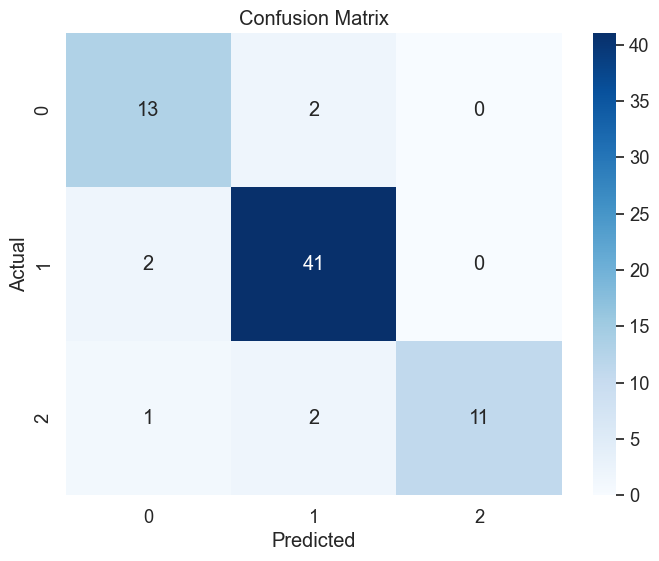

In [37]:
# Getting the predictions for the test set
pred = log_reg_model.predict(X_test_scaled)

# Creating the confusion matrix
c = confusion_matrix(y_test, pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for labels
sns.heatmap(c, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [38]:
print('\nAccuracy: {:.4f}\n'.format(accuracy_score(y_test, pred)))

print('Micro Precision: {:.2f}'.format(
    precision_score(y_test, pred, average='micro')))
print('Micro Recall: {:.2f}'.format(
    recall_score(y_test, pred, average='micro')))
print(
    'Micro F1-score: {:.2f}\n'.format(f1_score(y_test, pred, average='micro')))

print('Macro Precision: {:.2f}'.format(
    precision_score(y_test, pred, average='macro')))
print('Macro Recall: {:.2f}'.format(
    recall_score(y_test, pred, average='macro')))
print(
    'Macro F1-score: {:.2f}\n'.format(f1_score(y_test, pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(
    precision_score(y_test, pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(
    recall_score(y_test, pred, average='weighted')))
print(
    'Weighted F1-score: {:.2f}'.format(f1_score(y_test, pred, average='weighted')))

print('\nClassification Report\n')
print(classification_report(y_test, pred, target_names=[
      'Insomnia', 'None', 'Sleep Apnea']))


Accuracy: 0.9028

Micro Precision: 0.90
Micro Recall: 0.90
Micro F1-score: 0.90

Macro Precision: 0.91
Macro Recall: 0.87
Macro F1-score: 0.88

Weighted Precision: 0.91
Weighted Recall: 0.90
Weighted F1-score: 0.90

Classification Report

              precision    recall  f1-score   support

    Insomnia       0.81      0.87      0.84        15
        None       0.91      0.95      0.93        43
 Sleep Apnea       1.00      0.79      0.88        14

    accuracy                           0.90        72
   macro avg       0.91      0.87      0.88        72
weighted avg       0.91      0.90      0.90        72



### 2. Random Forest
Creating and Fitting the Random Forest model to the training set

In [39]:
random_forest_model = RandomForestClassifier().fit(X_train_scaled,y_train)

***Creating and Plotting the Confusion Matrix for the Test Set***

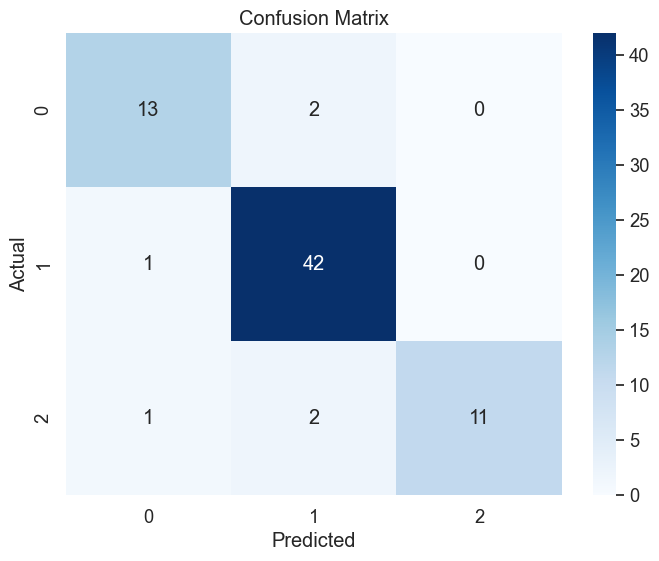

In [40]:
# Getting the predictions for the test set
pred = random_forest_model.predict(X_test_scaled)

# Creating the confusion matrix
c = confusion_matrix(y_test, pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for labels
sns.heatmap(c, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [41]:
print('\nAccuracy: {:.4f}\n'.format(accuracy_score(y_test, pred)))

print('Micro Precision: {:.2f}'.format(
    precision_score(y_test, pred, average='micro')))
print('Micro Recall: {:.2f}'.format(
    recall_score(y_test, pred, average='micro')))
print(
    'Micro F1-score: {:.2f}\n'.format(f1_score(y_test, pred, average='micro')))

print('Macro Precision: {:.2f}'.format(
    precision_score(y_test, pred, average='macro')))
print('Macro Recall: {:.2f}'.format(
    recall_score(y_test, pred, average='macro')))
print(
    'Macro F1-score: {:.2f}\n'.format(f1_score(y_test, pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(
    precision_score(y_test, pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(
    recall_score(y_test, pred, average='weighted')))
print(
    'Weighted F1-score: {:.2f}'.format(f1_score(y_test, pred, average='weighted')))

print('\nClassification Report\n')
print(classification_report(y_test, pred, target_names=[
      'Insomnia', 'None', 'Sleep Apnea']))


Accuracy: 0.9167

Micro Precision: 0.92
Micro Recall: 0.92
Micro F1-score: 0.92

Macro Precision: 0.93
Macro Recall: 0.88
Macro F1-score: 0.90

Weighted Precision: 0.92
Weighted Recall: 0.92
Weighted F1-score: 0.92

Classification Report

              precision    recall  f1-score   support

    Insomnia       0.87      0.87      0.87        15
        None       0.91      0.98      0.94        43
 Sleep Apnea       1.00      0.79      0.88        14

    accuracy                           0.92        72
   macro avg       0.93      0.88      0.90        72
weighted avg       0.92      0.92      0.92        72



In [42]:
# Feature importances of the model for each feature in Random Forest Classifier

feature_importances = random_forest_model.feature_importances_

feature_names = X_train.columns
importance_df = pd.DataFrame(
    {'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

                    Feature  Importance
7              bmi_category    0.181584
11                diastolic    0.162621
2                occupation    0.134619
10                 systolic    0.134240
1                       age    0.109438
3            sleep_duration    0.092729
5   physical_activity_level    0.087278
9               daily_steps    0.044663
6              stress_level    0.020394
4          quality_of_sleep    0.012807
8                heart_rate    0.012391
0                    gender    0.007234


### 3. XGBoost
Creating and Fitting the XGBoost model to the training set

In [43]:
xgb_model = XGBClassifier().fit(X_train_scaled,y_train)

***Creating and Plotting the Confusion Matrix for the Test Set***

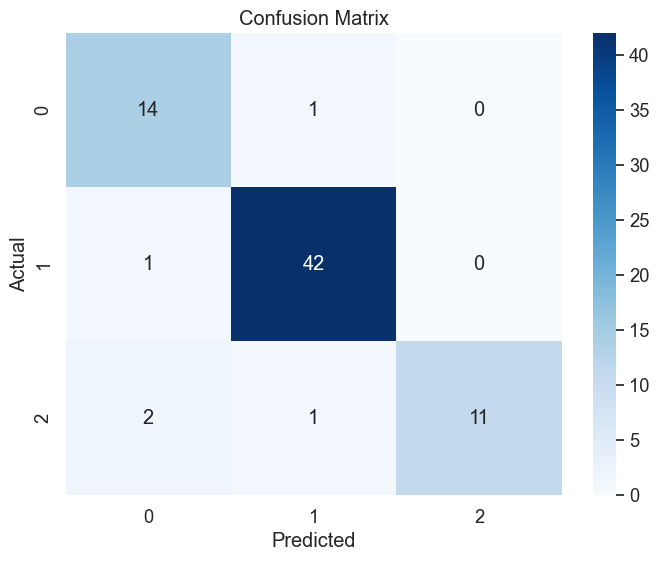

In [44]:
# Getting the predictions for the test set
pred = xgb_model.predict(X_test_scaled)

# Creating the confusion matrix
c = confusion_matrix(y_test, pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for labels
sns.heatmap(c, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [45]:
print('\nAccuracy: {:.4f}\n'.format(accuracy_score(y_test, pred)))

print('Micro Precision: {:.2f}'.format(
    precision_score(y_test, pred, average='micro')))
print('Micro Recall: {:.2f}'.format(
    recall_score(y_test, pred, average='micro')))
print(
    'Micro F1-score: {:.2f}\n'.format(f1_score(y_test, pred, average='micro')))

print('Macro Precision: {:.2f}'.format(
    precision_score(y_test, pred, average='macro')))
print('Macro Recall: {:.2f}'.format(
    recall_score(y_test, pred, average='macro')))
print(
    'Macro F1-score: {:.2f}\n'.format(f1_score(y_test, pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(
    precision_score(y_test, pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(
    recall_score(y_test, pred, average='weighted')))
print(
    'Weighted F1-score: {:.2f}'.format(f1_score(y_test, pred, average='weighted')))

print('\nClassification Report\n')
print(classification_report(y_test, pred, target_names=[
      'Insomnia', 'None', 'Sleep Apnea']))


Accuracy: 0.9306

Micro Precision: 0.93
Micro Recall: 0.93
Micro F1-score: 0.93

Macro Precision: 0.93
Macro Recall: 0.90
Macro F1-score: 0.91

Weighted Precision: 0.94
Weighted Recall: 0.93
Weighted F1-score: 0.93

Classification Report

              precision    recall  f1-score   support

    Insomnia       0.82      0.93      0.87        15
        None       0.95      0.98      0.97        43
 Sleep Apnea       1.00      0.79      0.88        14

    accuracy                           0.93        72
   macro avg       0.93      0.90      0.91        72
weighted avg       0.94      0.93      0.93        72



In [46]:
# Feature importances of the model for each feature in Random Forest Classifier

feature_importances = xgb_model.feature_importances_

feature_names = X_train.columns
importance_df = pd.DataFrame(
    {'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

                    Feature  Importance
7              bmi_category    0.734740
10                 systolic    0.157851
2                occupation    0.053823
5   physical_activity_level    0.015036
6              stress_level    0.007600
8                heart_rate    0.007509
1                       age    0.006047
0                    gender    0.005631
4          quality_of_sleep    0.004219
9               daily_steps    0.003801
3            sleep_duration    0.003744
11                diastolic    0.000000


## 6. Results and Conclusion

1. Logistic Regression had an accuracy of 0.90 and a weighted f1 score of 0.90

2. Random Forest had an accuracy of 0.916 and a weighted f1 score of 0.92

3. XGBoost had an accuracy of 0.93 and a weighted f1 score of 0.93

In our data exploration and analysis we assumed that the BMI Category was a strong indicator of the existance of a sleep disorder, our most reliable model `XGBoost` also showed that the BMI Category was the most important feature in predicting the existance of a sleep disorder.